# Set up and import dataset

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Set path to local data directory
folder_path = "/Users/dais/Downloads/Optiver_additional data"

# Define file paths
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Display dataset dimensions and column names
print("Feature DF:", feature_df.shape)
print("Target DF:", target_df.shape)
print("\nFeature columns:", feature_df.columns.tolist())
print("\nTarget columns:", target_df.columns.tolist())

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Preview top and bottom of the stacked DataFrame
print("\nConcat DF (head):")
display(combined_df.head())

print("\nConcat DF (tail):")
display(combined_df.tail())


Feature DF: (17646119, 11)
Target DF: (17911332, 11)

Feature columns: ['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

Target columns: ['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

Concat DF (head):


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,8382,6,1800.0,740.03,740.29,740.0,740.30,6,6,800,40
1,8382,6,1800.0,740.03,740.29,740.0,740.30,6,6,800,40
2,8382,6,1801.0,740.05,740.29,740.0,740.30,25,1,99,40
3,8382,6,1801.0,740.05,740.29,740.0,740.30,25,1,99,40
4,8382,6,1802.0,740.06,740.36,740.0,740.39,100,30,399,4



Concat DF (tail):


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
35557446,104919,1199,3595.0,362.73,362.74,362.72,362.75,200,1190,1200,1600
35557447,104919,1199,3596.0,362.68,362.70,362.67,362.71,800,200,1600,1400
35557448,104919,1199,3597.0,362.69,362.70,362.68,362.71,200,900,1400,1400
35557449,104919,1199,3598.0,362.72,362.73,362.71,362.74,200,1000,900,500
35557450,104919,1199,3599.0,362.80,362.81,362.79,362.82,200,300,600,300


# Feature Engineering

In [2]:
# Apply feature engineering function to the combined DataFrame (includes both first + last 30 min)
def compute_orderbook_features(df):
    """
    Compute engineered order book features from raw order book snapshots.
    """
    df = df.copy()

    # Mid price and Weighted Average Price
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
        df['bid_size1'] + df['ask_size1']
    )

    # Spread and relative spread
    df['bid_ask_spread'] = df['ask_price1'] - df['bid_price1']
    df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']

    # Spread variation over time within the same time_id
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # Order book imbalance and depth ratio
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['depth_ratio'] = df['bid_size1'] / df['ask_size1'].replace(0, np.nan)

    # Return only the engineered features
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation'
    ]
    return df[keep_cols]

# Apply feature engineering to the combined order book data
feature_engineered_df = compute_orderbook_features(combined_df)

# Preview result
feature_engineered_df.head()


,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation
0,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,NaN
1,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,0.000000
2,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016
3,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016
4,8382,6,1802.0,740.290769,0.000405,0.538462,3.333333,0.000033


In [3]:
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df.head()


,date,time,time_id
0,2021-01-05,11:00:00,12
1,2021-01-05,12:00:00,13
2,2021-01-05,13:00:00,14
3,2021-01-05,14:00:00,15
4,2021-01-05,15:00:00,16


# Combine date and time into a full datetime column


In [4]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])
time_ref_df.head()


,date,time,time_id,datetime
0,2021-01-05,11:00:00,12,2021-01-05 11:00:00
1,2021-01-05,12:00:00,13,2021-01-05 12:00:00
2,2021-01-05,13:00:00,14,2021-01-05 13:00:00
3,2021-01-05,14:00:00,15,2021-01-05 14:00:00
4,2021-01-05,15:00:00,16,2021-01-05 15:00:00


# Time ID to Real Time Mapping
NaT (Not a Time) means the merge didn’t find a matching time_id in time_ref_df
For example, time_id 6

In [5]:
# Re-do the merge and keep only the new datetime column
feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
feature_engineered_df.head()
feature_engineered_df.tail()


,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,datetime
35557446,104919,1199,3595.0,362.731439,0.000028,-0.712230,0.168067,0.000012,2021-10-07 16:00:00
35557447,104919,1199,3596.0,362.696000,0.000055,0.600000,4.000000,0.000012,2021-10-07 16:00:00
35557448,104919,1199,3597.0,362.691818,0.000028,-0.636364,0.222222,0.000012,2021-10-07 16:00:00
35557449,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012,2021-10-07 16:00:00
35557450,104919,1199,3599.0,362.804000,0.000028,-0.200000,0.666667,0.000012,2021-10-07 16:00:00


# Train/Test Split 
## Chronological time_id-based split (80/20)

In [6]:
# Sort just in case
feature_engineered_df = feature_engineered_df.sort_values(by="time_id")

# Unique time_ids
unique_ids = sorted(feature_engineered_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)

# Train on earliest 80%, test on latest 20%
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(train_ids)]
test_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(test_ids)]

print("TimeID Split:")
print("Train shape:", train_df_timeid.shape)
print("Test shape:", test_df_timeid.shape)


TimeID Split:
Train shape: (28513833, 9)
Test shape: (7043618, 9)


## Date-based split (e.g., train on one day, test on next)

In [7]:
# First, extract just the date
feature_engineered_df["date_only"] = feature_engineered_df["datetime"].dt.date

# Check available dates
print("Available Dates:", feature_engineered_df["date_only"].unique())

# Choose any pair of consecutive dates (example below)
train_day = pd.to_datetime("2021-09-30").date()
test_day = pd.to_datetime("2021-10-01").date()

train_df_date = feature_engineered_df[feature_engineered_df["date_only"] == train_day]
test_df_date = feature_engineered_df[feature_engineered_df["date_only"] == test_day]

print("Date-based Split:")
print("Train shape:", train_df_date.shape)
print("Test shape:", test_df_date.shape)


Available Dates: [NaT datetime.date(2021, 1, 5) datetime.date(2021, 1, 6)
 datetime.date(2021, 1, 7) datetime.date(2021, 1, 8)
 datetime.date(2021, 1, 11) datetime.date(2021, 1, 12)
 datetime.date(2021, 1, 13) datetime.date(2021, 1, 14)
 datetime.date(2021, 1, 15) datetime.date(2021, 1, 19)
 datetime.date(2021, 1, 20) datetime.date(2021, 1, 21)
 datetime.date(2021, 1, 22) datetime.date(2021, 1, 25)
 datetime.date(2021, 1, 26) datetime.date(2021, 1, 27)
 datetime.date(2021, 1, 28) datetime.date(2021, 1, 29)
 datetime.date(2021, 2, 1) datetime.date(2021, 2, 2)
 datetime.date(2021, 2, 3) datetime.date(2021, 2, 4)
 datetime.date(2021, 2, 5) datetime.date(2021, 2, 8)
 datetime.date(2021, 2, 9) datetime.date(2021, 2, 10)
 datetime.date(2021, 2, 11) datetime.date(2021, 2, 12)
 datetime.date(2021, 2, 16) datetime.date(2021, 2, 17)
 datetime.date(2021, 2, 18) datetime.date(2021, 2, 19)
 datetime.date(2021, 2, 22) datetime.date(2021, 2, 23)
 datetime.date(2021, 2, 24) datetime.date(2021, 2, 25)


# Modeling with one stock 
Each stock has its own dynamics, so we usually train per stock

Each stock might behave diffrently to diffrent models and will required diffrent tuning 

In [8]:
# Choosing stock 
feature_engineered_df["stock_id"].value_counts()


stock_id
50200     4166788
104919    4166348
9323      4156560
22951     3943343
8382      3908378
22753     3730669
22675     3305761
22771     2960979
22729     2681810
48219     2536815
Name: count, dtype: int64

In [9]:
# Example with SPY XNAS
spy_df = feature_engineered_df[feature_engineered_df["stock_id"] == 50200].copy()
print(spy_df.tail())

# Check the datetime available
spy_df["date_only"] = spy_df["datetime"].dt.date




          stock_id  time_id  seconds_in_bucket         wap  spread_pct  \
31387533     50200     1199               30.0  439.034667    0.000023   
31387532     50200     1199               29.0  439.032188    0.000023   
31387531     50200     1199               28.0  439.047386    0.000023   
31387529     50200     1199               26.0  439.050939    0.000023   
31391102     50200     1199             3599.0  438.577500    0.000023   

          imbalance  depth_ratio  spread_variation            datetime  \
31387533  -0.066511     0.875274      7.655920e-10 2021-10-07 16:00:00   
31387532  -0.562363     0.280112      8.471857e-10 2021-10-07 16:00:00   
31387531   0.477124     2.825000      8.471857e-10 2021-10-07 16:00:00   
31387529  -0.812207     0.103627      6.114179e-10 2021-10-07 16:00:00   
31391102   0.500000     3.000000      7.212521e-06 2021-10-07 16:00:00   

           date_only  
31387533  2021-10-07  
31387532  2021-10-07  
31387531  2021-10-07  
31387529  2021-10-

<Axes: title={'center': 'SPY: Spread % Over Time'}, xlabel='datetime'>

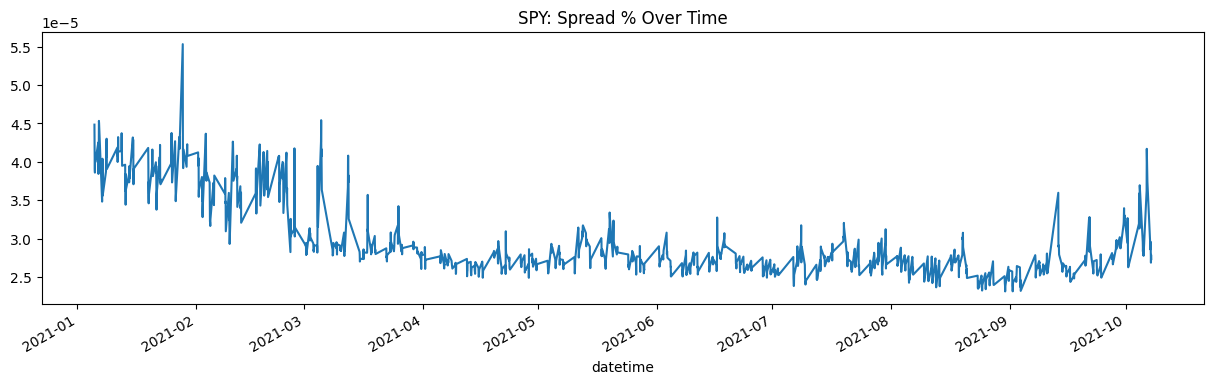

In [10]:
spy_df.groupby("datetime")["spread_pct"].mean().plot(
    figsize=(15,4), title="SPY: Spread % Over Time"
)

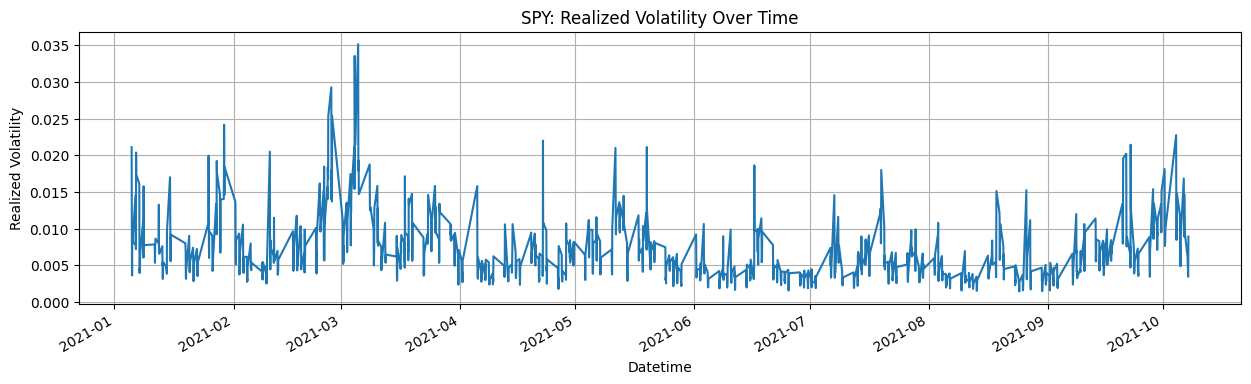

In [11]:
import numpy as np
import matplotlib.pyplot as plt

#  Compute log returns (per time_id)
spy_df["log_return"] = spy_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))


# Compute realized volatility per time_id
rv_df = spy_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()

rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into spy_df
spy_df = pd.merge(spy_df, rv_df, on="time_id", how="left")

# Plot volatility over time
spy_df.groupby("datetime")["realized_volatility"].mean().plot(
    figsize=(15, 4), title="SPY: Realized Volatility Over Time"
)
plt.xlabel("Datetime")
plt.ylabel("Realized Volatility")
plt.grid(True)
plt.show()



# HAV RV as baseline model
# Approach 1 : chronological train/test split on time id 80/20
## OLS

/var/folders/bl/t2w6yhtn14j4_glf4cb30yt80000gn/T/ipykernel_9599/589839108.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predicted_rv"] = hav_model.predict(X_test)


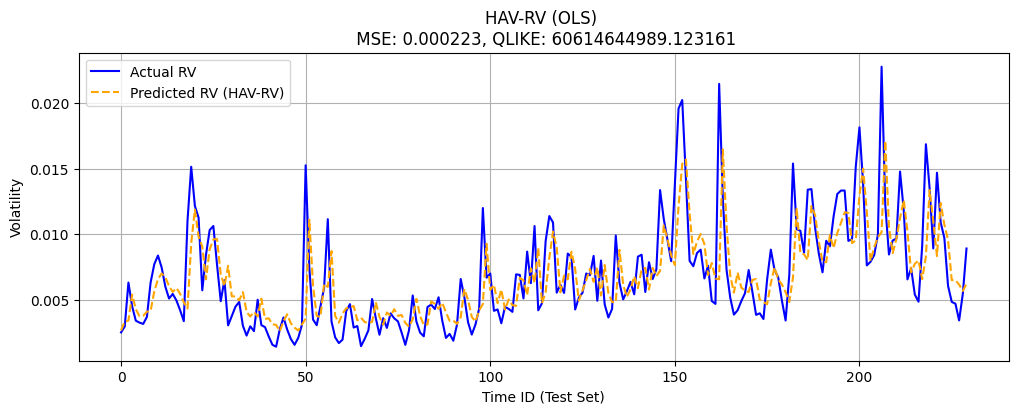

In [ ]:
hav_df = rv_df.copy()

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Start fresh and generate lags
hav_df = rv_df.copy()
hav_df["rv_lag_1"] = hav_df["realized_volatility"].shift(1)
hav_df["rv_lag_5"] = hav_df["realized_volatility"].shift(5)
hav_df["rv_lag_10"] = hav_df["realized_volatility"].shift(10)
hav_df = hav_df.dropna().reset_index(drop=True)

# Time-based train/test split
cutoff = int(len(hav_df) * 0.8)
train_df = hav_df.iloc[:cutoff]
test_df = hav_df.iloc[cutoff:]


# Fit model on training data
X_train = sm.add_constant(train_df[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
y_train = train_df["realized_volatility"]
hav_model = sm.OLS(y_train, X_train).fit()

#  Predict on test data
X_test = sm.add_constant(test_df[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
test_df["predicted_rv"] = hav_model.predict(X_test)



Test MSE: 0.00000798
Test QLIKE: -8.95805808


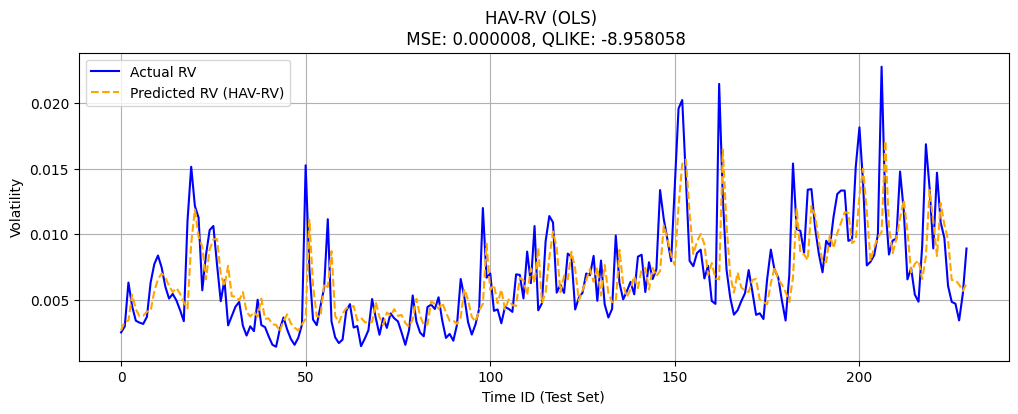

In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluate_model(true, pred):
    # Clip predicted values to avoid log(0) or division by 0
    pred_clipped = np.clip(pred, 1e-8, None)
    true = np.array(true)
    
    # MSE
    mse = mean_squared_error(true, pred_clipped)

    # QLIKE
    try:
        qlike_score = np.mean(np.log(pred_clipped**2) + (true**2) / (pred_clipped**2))
    except Exception as e:
        qlike_score = np.nan
        print("QLIKE calculation failed:", e)

    print(f"Test MSE: {mse:.8f}")
    print(f"Test QLIKE: {qlike_score:.8f}")

    return mse, qlike_score

# Example usage 
mse, qlike = evaluate_model(
    test_df["realized_volatility"].values,
    test_df["predicted_rv"].values
)

# Plot test results only (no leakage)
plt.figure(figsize=(12, 4))
plt.plot(test_df["realized_volatility"].values, label="Actual RV", color="blue")
plt.plot(test_df["predicted_rv"].values, label="Predicted RV (HAV-RV)", color="orange", linestyle="--")
plt.title(f"HAV-RV (OLS) \n MSE: {mse:.6f}, QLIKE: {qlike:.6f}")
plt.xlabel("Time ID (Test Set)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()



## wls

MSE: 0.00001045
QLIKE: -8.66536951


/var/folders/bl/t2w6yhtn14j4_glf4cb30yt80000gn/T/ipykernel_9599/2988443605.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predicted_rv_wls"] = wls_model.predict(X_test)


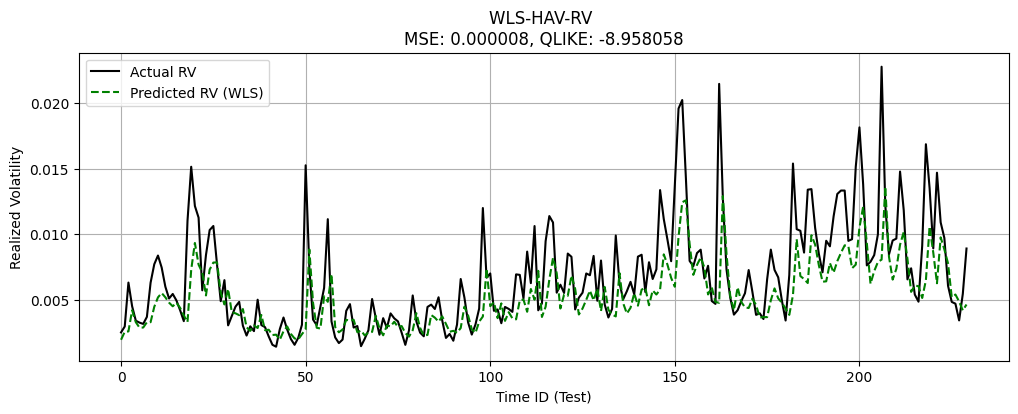

In [22]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Time-based train/test split
cutoff = int(len(hav_df) * 0.8)
train_df = hav_df.iloc[:cutoff]
test_df = hav_df.iloc[cutoff:]

#  Prepare features
X_train = sm.add_constant(train_df[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
y_train = train_df["realized_volatility"]

X_test = sm.add_constant(test_df[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
y_test = test_df["realized_volatility"]

# Fit WLS model (weighted by inverse volatility squared)
weights = 1 / (y_train ** 2)
wls_model = sm.WLS(y_train, X_train, weights=weights).fit()

# Predict on test set
test_df["predicted_rv_wls"] = wls_model.predict(X_test)

# Evaluate
mse_wls, qlike_wls = evaluate_model(y_test, test_df["predicted_rv_wls"])

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label="Actual RV", color="black")
plt.plot(test_df["predicted_rv_wls"].values, label="Predicted RV (WLS)", color="green", linestyle="--")
plt.title(f"WLS-HAV-RV \nMSE: {mse:.6f}, QLIKE: {qlike:.6f}")
plt.xlabel("Time ID (Test)")
plt.ylabel("Realized Volatility")
plt.legend()
plt.grid(True)
plt.show()

## To be fixed  HAV-RV (Rolling 5-hour Train → 1-hour Predict)

✅ MSE: 0.00022333
✅ QLIKE: 60614644989.12316132


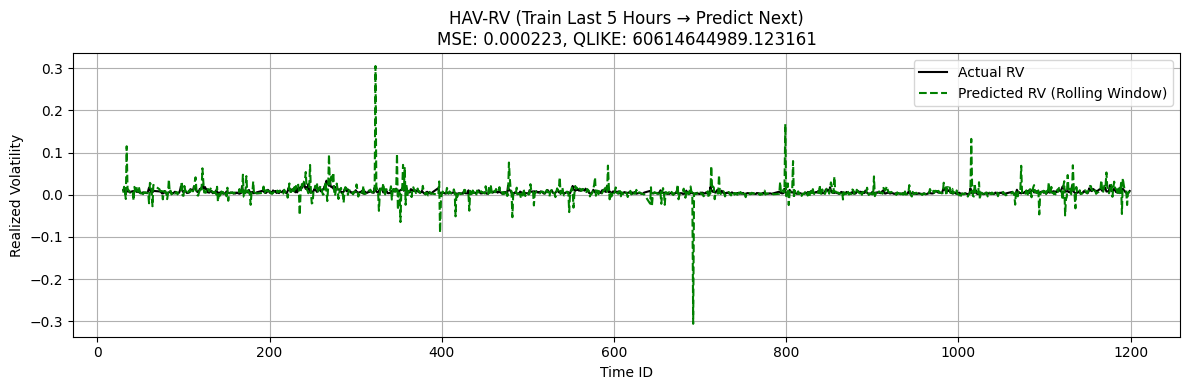

In [ ]:

# Create lag features
hav_df = rv_df.copy()
hav_df["rv_lag_1"] = hav_df["realized_volatility"].shift(1)
hav_df["rv_lag_5"] = hav_df["realized_volatility"].shift(5).rolling(window=5).mean()
hav_df["rv_lag_10"] = hav_df["realized_volatility"].shift(10).rolling(window=10).mean()
hav_df = hav_df.dropna().reset_index(drop=True)

# Rolling train on last 5 rows, predict the next (1-hour ahead)
predictions = []
actuals = []
time_ids_out = []

window_size = 5  # Train on past 5 hours

for i in range(window_size, len(hav_df)):
    train = hav_df.iloc[i - window_size:i]   # Last 5 rows (past 5 hours)
    test = hav_df.iloc[[i]]                  # Current row (next hour)

    X_train = sm.add_constant(train[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
    y_train = train["realized_volatility"]
    X_test = pd.DataFrame(
    sm.add_constant(test[["rv_lag_1", "rv_lag_5", "rv_lag_10"]], has_constant="add"),
    columns=X_train.columns  # force column alignment
)


    model = sm.OLS(y_train, X_train).fit()
    pred = model.predict(X_test).values[0]

    predictions.append(pred)
    actuals.append(test["realized_volatility"].values[0])
    time_ids_out.append(test["time_id"].values[0])

# Evaluate with clipping to avoid QLIKE errors
predictions_clipped = np.clip(predictions, 1e-8, None)
mse = mean_squared_error(actuals, predictions_clipped)
qlike = np.mean(np.log(predictions_clipped**2) + (np.array(actuals)**2) / (predictions_clipped**2))

print(f"MSE: {mse:.8f}")
print(f"QLIKE: {qlike:.8f}")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(time_ids_out, actuals, label="Actual RV", color="black")
plt.plot(time_ids_out, predictions, label="Predicted RV (Rolling Window)", color="green", linestyle="--")
plt.title(f"HAV-RV (Train Last 5 Hours → Predict Next)\nMSE: {mse:.6f}, QLIKE: {qlike:.6f}")
plt.xlabel("Time ID")
plt.ylabel("Realized Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#!pip install statsmodels
#!pip install scikit-learn

